In [17]:
import os
from os.path import isfile, join, isdir
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)
sns.set(style="whitegrid")

In [18]:
# https://www.music-ir.org/mirex/wiki/2020:Audio_Chord_Estimation
maj_chords = set(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
min_chords = set([c + 'm' for c in maj_chords])

seventh_labels = ['maj7', 'min7', '7']
seventh_chords = set([c + l for l in seventh_labels for c in list(maj_chords)])

inversions_labels = ['/3', 'min/b3', '/5', 'min/5']
inversions_chords = set([c + l for l in inversions_labels for c in list(maj_chords)])

seventh_inversions_labels = ['maj7/3', 'min7/b3', '7/3', 'maj7/5', 'min7/5', '7/5', 'maj7/7', 'min7/b7', '7/b7']

In [45]:
from utils import read_csv

def build_dataset(mypath, sep=' '):
    datasets = []
    dirs = [f for f in os.listdir(mypath) if isdir(join(mypath, f))]
    for directory in dirs:
        for file_name in os.listdir(mypath + directory):
            file_path = join(mypath, directory, file_name)
            if isfile(file_path) and file_path.endswith('.lab'):
                chords_df = read_csv(file_path, sep=sep)
                datasets.append(chords_df)
                
    chords_df = pd.concat(datasets)
    chords_df.columns = ['start', 'end', 'label']
    return chords_df

def build_file_dataset(file_path, sep=' '):
    chords_df = pd.DataFrame()
    if isfile(file_path) and file_path.endswith('.lab'):
        chords_df = read_csv(file_path, sep=sep)
    chords_df.columns = ['start', 'end', 'label']
    return chords_df

def mark_vocabulary(label):
    if label in maj_chords:
        return 'maj'
    elif label in min_chords:
        return 'min'
    elif label in seventh_chords:
        return 'seventh'
    elif label in inversions_chords:
        return 'inv'
    elif label == 'N':
        return 'N'
    else:
        return 'other'

In [27]:
def preprocess_chords(df):
    chords_df = df.copy()
    # For details, see https://www.music-ir.org/mirex/wiki/2020:Audio_Chord_Estimation
    chords_df['label'] = chords_df.label.str.replace('Db', 'C#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('Eb', 'D#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('Gb', 'F#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('Ab', 'G#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('Bb', 'A#', regex=False)
    
    chords_df['label'] = chords_df.label.str.replace('C:maj', 'C', regex=False)
    chords_df['label'] = chords_df.label.str.replace('C#:maj', 'C#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('D:maj', 'D', regex=False)
    chords_df['label'] = chords_df.label.str.replace('D#:maj', 'D#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('E:maj', 'E', regex=False)
    chords_df['label'] = chords_df.label.str.replace('F:maj', 'F', regex=False)
    chords_df['label'] = chords_df.label.str.replace('F#:maj', 'F#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('G:maj', 'G', regex=False)
    chords_df['label'] = chords_df.label.str.replace('G#:maj', 'G#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('A:maj', 'A', regex=False)
    chords_df['label'] = chords_df.label.str.replace('A#:maj', 'A#', regex=False)
    chords_df['label'] = chords_df.label.str.replace('B:maj', 'B', regex=False)
    
    chords_df['label'] = chords_df.label.str.replace(':maj7', 'maj7', regex=False)
    chords_df['label'] = chords_df.label.str.replace(':min7', 'min7', regex=False)
    chords_df['label'] = chords_df.label.str.replace(':min', 'm', regex=True)
    chords_df['label'] = chords_df.label.str.replace(':7', '7', regex=True)
    
    chords_df['vocab'] = chords_df.label.apply(lambda x: mark_vocabulary(x))
    return chords_df

In [39]:
def chord_distribution(df, title='Chord distribution'):
    print(chords_df.groupby('vocab').size() / len(chords_df))
    ax = sns.countplot(x="vocab", hue='vocab', data=df, dodge=False).set_title(title)

In [50]:
beatles_df = build_dataset('data/beatles/chordlabs/')
queen_df = build_dataset('data/queen/chordlabs/', sep='\t')
cking_df = build_dataset('data/carole_king/', sep='\t')
chords_df = pd.concat([beatles_df, queen_df])

vocab
N          0.027583
inv        0.050756
maj        0.561077
min        0.144092
other      0.131330
seventh    0.085161
dtype: float64


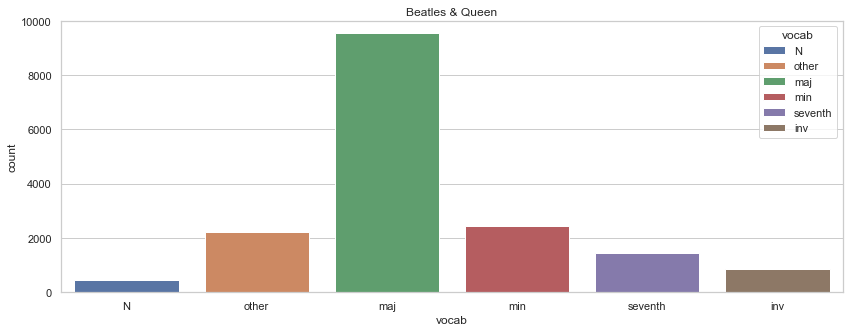

In [51]:
chords_df = preprocess_chords(chords_df)
chord_distribution(chords_df, 'Beatles & Queen')

vocab
N          0.027583
inv        0.050756
maj        0.561077
min        0.144092
other      0.131330
seventh    0.085161
dtype: float64


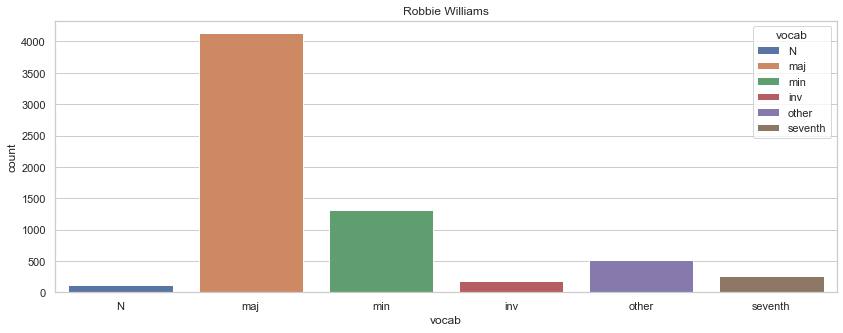

In [42]:
rwilliams_df = build_dataset('data/robbie_williams/chordlabs/', sep='\t')
df = preprocess_chords(rwilliams_df)
chord_distribution(df, 'Robbie Williams')

vocab
N          0.027583
inv        0.050756
maj        0.561077
min        0.144092
other      0.131330
seventh    0.085161
dtype: float64


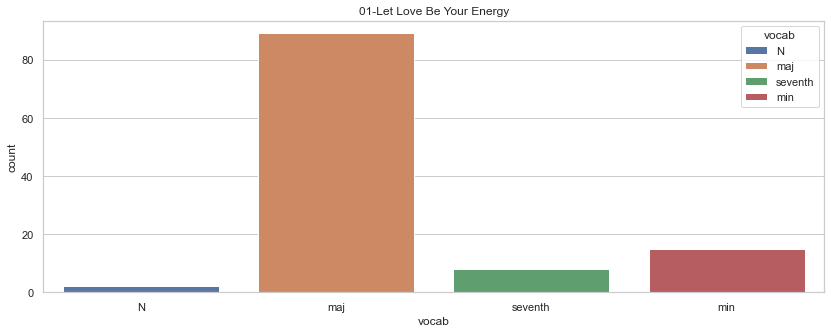

In [47]:
df = build_file_dataset("data/robbie_williams/chordlabs/2000-Sing When You're Winning/01-Let Love Be Your Energy.lab", sep='\t')
df = preprocess_chords(df)
chord_distribution(df, '01-Let Love Be Your Energy')

In [70]:
df.groupby('label').nunique()

,start,end,label,vocab
label,,,,
A#,12,12,1,1
B7,2,2,1,1
Bm,6,6,1,1
C#,6,6,1,1
D#,31,31,1,1
D#m,6,6,1,1
F#,18,18,1,1
F#7,6,6,1,1
Fm,3,3,1,1


In [85]:
chords_df[chords_df.label.isin(list(maj_chords) + list(min_chords))].groupby('label').nunique().sort_values('start', ascending=False)
#chords_df.groupby('label').nunique().sort_values('start', ascending=False)

,start,end,label,vocab
label,,,,
A,1794,1794,1,1
G,1559,1558,1,1
D,1551,1550,1,1
C,1134,1136,1,1
E,1078,1078,1,1
F,547,547,1,1
B,539,539,1,1
Am,435,435,1,1
A#,410,410,1,1


In [81]:
pd.options.display.max_rows = 500
#pd.set_option('max_rows', 25)